In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "data/mouse_drug_data.csv"
clinical_trial_data_to_load = "data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(mouse_drug_data_to_load)
trial_df = pd.read_csv(clinical_trial_data_to_load)

Let's have a look at the data

In [2]:
mouse_df.head()

,Mouse ID,Drug
0,f234,Stelasyn
1,x402,Stelasyn
2,a492,Stelasyn
3,w540,Stelasyn
4,v764,Stelasyn


In [3]:
trial_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


Mouse ID is the clear column to join on. But before that, let's take a look at some basic info about the datasets.

In [4]:
mouse_df.info()
mouse_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
Mouse ID    250 non-null object
Drug        250 non-null object
dtypes: object(2)
memory usage: 4.0+ KB


,Mouse ID,Drug
count,250,250
unique,249,10
top,g989,Ramicane
freq,2,25


In [5]:
trial_df.info()
trial_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893 entries, 0 to 1892
Data columns (total 4 columns):
Mouse ID              1893 non-null object
Timepoint             1893 non-null int64
Tumor Volume (mm3)    1893 non-null float64
Metastatic Sites      1893 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 59.2+ KB


,Timepoint,Tumor Volume (mm3),Metastatic Sites
count,1893.000000,1893.000000,1893.000000
mean,19.572108,50.455258,1.021659
std,14.079460,8.888824,1.137974
min,0.000000,22.050126,0.000000
25%,5.000000,45.000000,0.000000
50%,20.000000,48.957919,1.000000
75%,30.000000,56.292200,2.000000
max,45.000000,78.567014,4.000000


Here, I can see that the data is very clean in that there are no null values in either dataset. We also see that the trials went on for 45 days.

Any Mouse IDs that are in one dataset but not the other?

In [6]:
mouse_MID = list(mouse_df["Mouse ID"].value_counts().index)
trial_MID = list(trial_df["Mouse ID"].value_counts().index)

def missing_mice(left, right):
    missing_mice_count = 0
    
    for mouse_id in left:
        if mouse_id not in right:
            missing_mice_count += 1
    
    return missing_mice_count

mouse_df_only = missing_mice(mouse_MID, trial_MID)
trial_df_only = missing_mice(trial_MID, mouse_MID)
print(f"Mouse IDs in mouse_df only: {mouse_df_only}")
print(f"Mouse IDs in trial_df only: {trial_df_only}")

Mouse IDs in mouse_df only: 0
Mouse IDs in trial_df only: 0


No duplicate Mouse IDs. What about repeated mice?

In [7]:
drug_count = mouse_df.groupby("Mouse ID").agg({"Drug":"count"})
drug_count.query("Drug > 1")

,Drug
Mouse ID,
g989,2


Hey, what a minute, why does this mouse get two drugs? That doesn't seem right. Which drugs is it subjected to?

In [8]:
mouse_df[mouse_df["Mouse ID"] == 'g989']

,Mouse ID,Drug
7,g989,Stelasyn
173,g989,Propriva


Neither of these drugs are in scope for this analysis. We can simply remove them then because it is unknown how the Mouse ID appear twice. Could be some sort of error but since we do not analyze either of these drugs, we can safely remove these records.

In [9]:
mouse_df = mouse_df[mouse_df["Mouse ID"] != 'g989']
mouse_df.describe()

,Mouse ID,Drug
count,248,248
unique,248,10
top,w150,Ramicane
freq,1,25


Ok, now we're good to join by Mouse ID (any join will do in this case but we'll do an inner join here)!

In [10]:
# Combine the data into a single dataset
combined_df = pd.merge(trial_df, mouse_df, on="Mouse ID", how="inner")

# Display the data table for preview
combined_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


In [11]:
# get all the possible drugs
mouse_df["Drug"].value_counts()

Ramicane     25
Ceftamin     25
Naftisol     25
Capomulin    25
Ketapril     25
Placebo      25
Infubinol    25
Zoniferol    25
Propriva     24
Stelasyn     24
Name: Drug, dtype: int64

In [12]:
# but we only care about these drugs
selected_drugs = ["Capomulin","Infubinol","Ketapril","Placebo"]
[print(x) for x in selected_drugs];

Capomulin
Infubinol
Ketapril
Placebo


## Tumor Response to Treatment

In [13]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint as DataFrame
mean_tumor_response_df = combined_df.groupby(["Drug","Timepoint"],as_index=False).agg({"Tumor Volume (mm3)":"mean"})

# Preview DataFrame
mean_tumor_response_df.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325


In [14]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint as DataFrame
sem_tumor_response_df = combined_df.groupby(["Drug","Timepoint"],as_index=False).agg({"Tumor Volume (mm3)":"sem"})

# Preview DataFrame
sem_tumor_response_df.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [15]:
# Minor Data Munging to Re-Format the Data Frames
reshaped_mean_df = mean_tumor_response_df.pivot(index="Timepoint", columns = "Drug")

# Preview that Reformatting worked
reshaped_mean_df.columns = reshaped_mean_df.columns.droplevel()
reshaped_mean_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.168130,43.944859,47.470830,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,48.938560,42.531957,49.335368,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,50.891769,41.495061,51.448025,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.127384,40.238325,53.970080,53.170334


In [16]:
# Minor Data Munging to Re-Format the Data Frames
reshaped_sem_df = sem_tumor_response_df.pivot(index="Timepoint", columns = "Drug")

# Preview that Reformatting worked
reshaped_sem_df.columns = reshaped_sem_df.columns.droplevel()
reshaped_sem_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.448593,0.164505,0.235102,0.264819,0.202385,0.218091,0.241842,0.482955,0.254830,0.188950
10,0.702684,0.236144,0.282346,0.357421,0.319415,0.402064,0.388701,0.720225,0.461474,0.263949
15,0.838617,0.332053,0.357705,0.580268,0.444378,0.614461,0.502024,0.770432,0.532904,0.370544
20,0.909731,0.359482,0.476210,0.726484,0.595260,0.839609,0.607412,0.786199,0.684670,0.533182


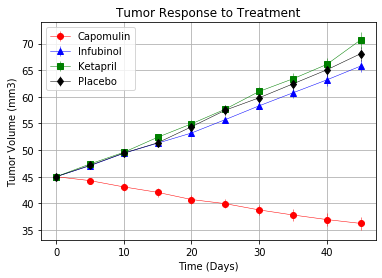

In [17]:
# Generate the Plot (with Error Bars)
drugs = {"Capomulin":['o','r'],
         "Infubinol":['^','b'],
         "Ketapril":['s','g'],
         "Placebo":['d','k']
        }

for drug,styles in drugs.items():
    plt.errorbar(list(reshaped_mean_df.index), reshaped_mean_df[drug],reshaped_sem_df[drug], 
                 linewidth=0.5, label=drug, marker=styles[0], color=styles[1]);

plt.title("Tumor Response to Treatment");
plt.xlabel("Time (Days)");
plt.ylabel("Tumor Volume (mm3)");
plt.legend();
plt.grid()

# Save the Figure
plt.savefig("images/tumor_response_to_treatment.png")

I can see that of the four drugs in question, Capomulin is clearly the best one as it is the ONLY drug where the tumor volume size decreases over 45 days. The other three treatments increase in volume over time and while they start out pretty close together, they start to get more pronounced by day 45.

Infubinol is slightly better than the placebo but the mice weren't much better off in the end. Ketapril is actually slightly worse. Wouldn't want a drug that increases the size of a tumor! However, I can also see that the error bars for Infobinol and Ketapril cross into the placebo plot so actually, I can't say they are any better at all in a statistical sense!

## Metastatic Response to Treatment

In [18]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint and convert to DataFrame
mean_metastatic_df = combined_df.groupby(["Drug","Timepoint"], as_index=False).agg({"Metastatic Sites":"mean"})

# Preview DataFrame
mean_metastatic_df.head()

,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.160000
2,Capomulin,10,0.320000
3,Capomulin,15,0.375000
4,Capomulin,20,0.652174


In [19]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint and convert to DataFrame
sem_metastatic_df = combined_df.groupby(["Drug","Timepoint"], as_index=False).agg({"Metastatic Sites":"sem"})

# Preview DataFrame
sem_metastatic_df.head()

,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.074833
2,Capomulin,10,0.125433
3,Capomulin,15,0.132048
4,Capomulin,20,0.161621


In [20]:
# Minor Data Munging to Re-Format the Data Frames
reshaped_mean_metastatic_df = mean_metastatic_df.pivot(index="Timepoint", columns = "Drug")

# Preview that Reformatting worked
reshaped_mean_metastatic_df.columns = reshaped_mean_metastatic_df.columns.droplevel()
reshaped_mean_metastatic_df

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.347826,0.120000,0.260870,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.619048,0.250000,0.523810,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.800000,0.333333,0.809524,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.947368,1.294118
25,0.818182,1.500000,1.277778,1.631579,1.500000,1.941176,1.384615,0.652174,1.166667,1.687500
30,1.090909,1.937500,1.588235,2.055556,2.066667,2.266667,1.666667,0.782609,1.411765,1.933333
35,1.181818,2.071429,1.666667,2.294118,2.266667,2.642857,2.333333,0.952381,1.533333,2.285714
40,1.380952,2.357143,2.100000,2.733333,2.466667,3.166667,2.777778,1.100000,1.583333,2.785714


In [21]:
# Minor Data Munging to Re-Format the Data Frames
reshaped_sem_metastatic_df = sem_metastatic_df.pivot(index="Timepoint", columns = "Drug")

# Preview that Reformatting worked
reshaped_sem_metastatic_df.columns = reshaped_sem_metastatic_df.columns.droplevel()
reshaped_sem_metastatic_df

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.074833,0.108588,0.091652,0.098100,0.093618,0.100947,0.101543,0.066332,0.093618,0.077709
10,0.125433,0.152177,0.159364,0.142018,0.163577,0.115261,0.108588,0.090289,0.131277,0.109109
15,0.132048,0.180625,0.194015,0.191381,0.158651,0.190221,0.144749,0.115261,0.163577,0.111677
20,0.161621,0.241034,0.234801,0.236680,0.181731,0.234064,0.195180,0.119430,0.222607,0.166378
25,0.181818,0.258831,0.265753,0.288275,0.185240,0.263888,0.212990,0.119430,0.232210,0.236621
30,0.172944,0.249479,0.227823,0.347467,0.266667,0.300264,0.284268,0.139968,0.243426,0.248168
35,0.169496,0.266526,0.224733,0.361418,0.330464,0.341412,0.408248,0.145997,0.255728,0.285714
40,0.175610,0.289128,0.314466,0.315725,0.321702,0.297294,0.433903,0.160591,0.312815,0.299791


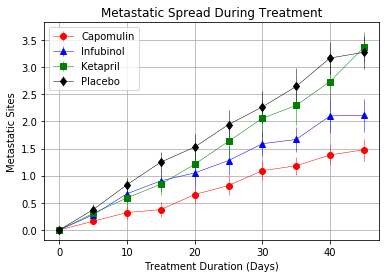

In [22]:
# Generate the Plot (with Error Bars)
drugs = {"Capomulin":['o','r'],
         "Infubinol":['^','b'],
         "Ketapril":['s','g'],
         "Placebo":['d','k']
        }

for drug,styles in drugs.items():
    plt.errorbar(list(reshaped_mean_metastatic_df.index), reshaped_mean_metastatic_df[drug],reshaped_sem_metastatic_df[drug], 
                 linewidth=0.5, label=drug, marker=styles[0], color=styles[1]);

plt.title("Metastatic Spread During Treatment");
plt.xlabel("Treatment Duration (Days)");
plt.ylabel("Metastatic Sites");
plt.legend();
plt.grid()

# Save the Figure
plt.savefig("images/metastatic_spread_during_treatment.png")

What can be said about the number of metastatic sites during treatment?

Again, Capomulin is the best drug treatment as it has the lowest number of metastatic sites by 45 days. Infubinol is statistically different from the placebo in having a lower number of metastatic sites. But Ketapril is not. Those two drugs also have larger error bars than Capomulin does.

## Survival Rates

In [23]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
mice_count_df = combined_df.groupby(["Drug","Timepoint"], as_index=False).agg({"Mouse ID":"count"})

# Preview DataFrame
mice_count_df.rename(columns={"Mouse ID":"Mouse Count"},inplace=True)
mice_count_df.head()

,Drug,Timepoint,Mouse Count
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


In [24]:
# Minor Data Munging to Re-Format the Data Frames
reshaped_mice_count_df = mice_count_df.pivot(index="Timepoint", columns = "Drug")

# Preview that Reformatting worked
reshaped_mice_count_df.columns = reshaped_mice_count_df.columns.droplevel()
reshaped_mice_count_df

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,24,25,24,25
5,25,21,25,23,23,24,23,25,23,24
10,25,20,21,22,21,24,21,24,21,22
15,24,19,21,19,21,20,15,24,21,21
20,23,18,20,19,20,19,15,23,19,17
25,22,18,18,19,18,17,13,23,18,16
30,22,16,17,18,15,15,12,23,17,15
35,22,14,12,17,15,14,9,21,15,14
40,21,14,10,15,15,12,9,20,12,14


In [25]:
initial_mouse_count = list(reshaped_mice_count_df.iloc[0,:])

def get_percent_mouse_alive(row):
    return row / initial_mouse_count * 100

percent_survival_df = reshaped_mice_count_df.apply(get_percent_mouse_alive)
percent_survival_df

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,100.000000,100.000000,100.000000,100.0,100.0,100.0,96.0,100.000000,96.000000,100.000000
5,100.000000,84.000000,100.000000,92.0,92.0,96.0,92.0,100.000000,92.000000,96.000000
10,100.000000,80.000000,84.000000,88.0,84.0,96.0,84.0,96.000000,84.000000,88.000000
15,96.000000,76.000000,84.000000,76.0,84.0,80.0,60.0,96.000000,84.000000,84.000000
20,92.000000,72.000000,80.000000,76.0,80.0,76.0,60.0,92.000000,76.000000,68.000000
25,88.000000,72.000000,72.000000,76.0,72.0,68.0,52.0,92.000000,72.000000,64.000000
30,91.666667,66.666667,70.833333,75.0,62.5,62.5,50.0,95.833333,70.833333,62.500000
35,88.000000,56.000000,48.000000,68.0,60.0,56.0,36.0,84.000000,60.000000,56.000000
40,87.500000,58.333333,41.666667,62.5,62.5,50.0,37.5,83.333333,50.000000,58.333333


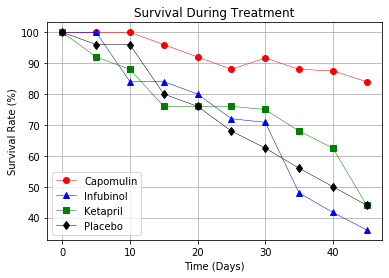

In [26]:
# Generate the Plot (Accounting for percentages)
drugs = {"Capomulin":['o','r'],
         "Infubinol":['^','b'],
         "Ketapril":['s','g'],
         "Placebo":['d','k']
        }

for drug,styles in drugs.items():
    plt.plot(list(percent_survival_df.index), percent_survival_df[drug], 
             linewidth=0.5, label=drug, marker=styles[0], color=styles[1]);

plt.title("Survival During Treatment");
plt.xlabel("Time (Days)");
plt.ylabel("Survival Rate (%)");
plt.legend();
plt.grid()

# Save the Figure
plt.savefig("images/survival_during_treatment.png")

Survival rate is highest with Capomulin, unsurprisingly.

Other drugs are about in line with the placebo for most of the time. About 10% worse with Infubinol in the end though.

## Summary Bar Graph

In [27]:
# Calculate the percent changes for each drug
init_tumor_size = reshaped_mean_df.iloc[0]
final_tumor_size = reshaped_mean_df.iloc[-1]
pct_tumor_size_change = (final_tumor_size - init_tumor_size) / init_tumor_size * 100

# Display the data to confirm
pct_tumor_size_change

Drug
Capomulin   -19.475303
Ceftamin     42.516492
Infubinol    46.123472
Ketapril     57.028795
Naftisol     53.923347
Placebo      51.297960
Propriva     47.241175
Ramicane    -22.320900
Stelasyn     52.085134
Zoniferol    46.579751
dtype: float64

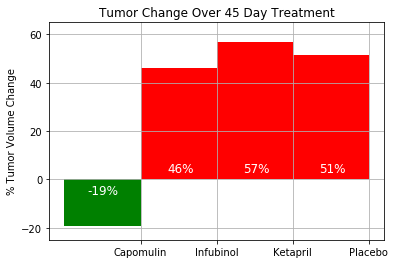

In [28]:
# Store all Relevant Percent Changes into a Tuple
drugs = ["Capomulin","Infubinol","Ketapril","Placebo"]
pct_change_drugs = list(pct_tumor_size_change[drugs])
drugs_pct_change_dict = dict(zip(drugs, pct_change_drugs))

# Splice the data between passing and failing drugs
passing_drugs = {key:value for (key,value) in drugs_pct_change_dict.items() if drugs_pct_change_dict[key] < 0}
failing_drugs = {key:value for (key,value) in drugs_pct_change_dict.items() if drugs_pct_change_dict[key] > 0}

# Orient widths. Add labels, tick marks, etc. 
plt.bar(passing_drugs.keys(),passing_drugs.values(), color="g", align='edge', width=-1);
plt.bar(failing_drugs.keys(),failing_drugs.values(), color="r", align='edge', width=-1);
plt.title("Tumor Change Over 45 Day Treatment");
plt.ylabel("% Tumor Volume Change");
plt.ylim(-25,65)
plt.yticks(np.arange(-20, 80, 20))
plt.grid()

# Use functions to label the percentages of changes
for key in passing_drugs.keys():
    plt.annotate(f"{round(passing_drugs[key])}%",(-.7,-6), color='white', fontsize=12);

counter = 0.35
for key in failing_drugs.keys():
    plt.annotate(f"{round(failing_drugs[key])}%",(counter,3), color='white', fontsize=12);
    counter += 1

# Save the Figure
plt.savefig("images/tumor_change_45_days.png")

This bar plot agrees with previous assessments. Capomulin is the best drug since it's the only one that decreases tumor volume at the end of the 45 day treatment (the only green one!). All the rest have percent increases of about the same as the placebo treatment. 

Above, I created a standard bar chart. However, I typically tend to like horizontal bar charts a lot more since everything is read in the same direction and I find it easier to read and interpret. Also, the code for it is a lot shorter because I don't have to account for exact position of annotations nearly as perfectly (or at least in the way I know how)! I mean, take a look at this:

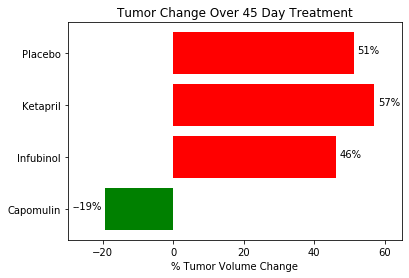

In [29]:
plt.barh(list(passing_drugs.keys()),passing_drugs.values(), color="g");
plt.barh(list(failing_drugs.keys()),failing_drugs.values(), color="r");
plt.title("Tumor Change Over 45 Day Treatment");
plt.xlabel("% Tumor Volume Change");
plt.xlim(-30,65)

pass_counter = 0
for key in passing_drugs.keys():
    plt.annotate(f"-{round(passing_drugs[key])}%",(passing_drugs[key] - 9,pass_counter));

fail_counter = 1
for key in failing_drugs.keys():
    plt.annotate(f"{round(failing_drugs[key])}%",(failing_drugs[key] + 1,fail_counter));
    fail_counter +=1

This is way easier to read, in my opinion!

# Conclusions

A summary of observations made about this analysis:

* Capomulin is clearly the best one as it is the ONLY drug where the tumor volume size decreases over 45 days. The other two drug treatments are pretty similar in terms of tumor volume size over time and are not statistically different from the placebo
* Capomulin is the best drug treatment as it has the lowest number of metastatic sites by 45 days. Infubinol is statistically different from the placebo in having a lower number of metastatic sites but Ketapril is not
* Survival rate is also highest using Capomulin. The other two drugs have pretty similar rates to the placebo, although the rate is lowest for Infubinol in the end
* Capomulin is overall best drug for treatment hands down
* Horizontal bar charts >>> standard bar charts